## 第5章回归分析

In [1]:
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## 图像在jupyter notebook中显示
%matplotlib inline
## 显示的图片格式（mac中的高清格式），还可以设置为"bmp"等格式
%config InlineBackend.figure_format = "retina"
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

分析建筑物的供热负荷和制冷负荷要求（即能源效率）与建筑参数的关系。
能效数据集http://archive.ics.uci.edu/ml/datasets/Energy+efficiency

X1相对紧凑

X2表面积

X3墙面积

X4屋顶区域

X5总高度

X6方向

X7玻璃区域

X8玻璃面积分布

y1加热负载

y2冷却负荷

In [2]:
## 读取数据集
Enb = pd.read_excel("data/chap5/ENB2012_data.xlsx")
print(Enb.sample(5))


       X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
689  0.79  637.0  343.0  147.0  7.0   3  0.40   4  41.73  47.59
557  0.71  710.5  269.5  220.5  3.5   3  0.40   1  14.60  17.51
527  0.62  808.5  367.5  220.5  3.5   5  0.25   5  13.86  14.75
486  0.90  563.5  318.5  122.5  7.0   4  0.25   5  31.53  37.19
645  0.76  661.5  416.5  122.5  7.0   3  0.40   3  39.84  38.48


In [3]:
## 查看数据是否有缺失值
Enb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


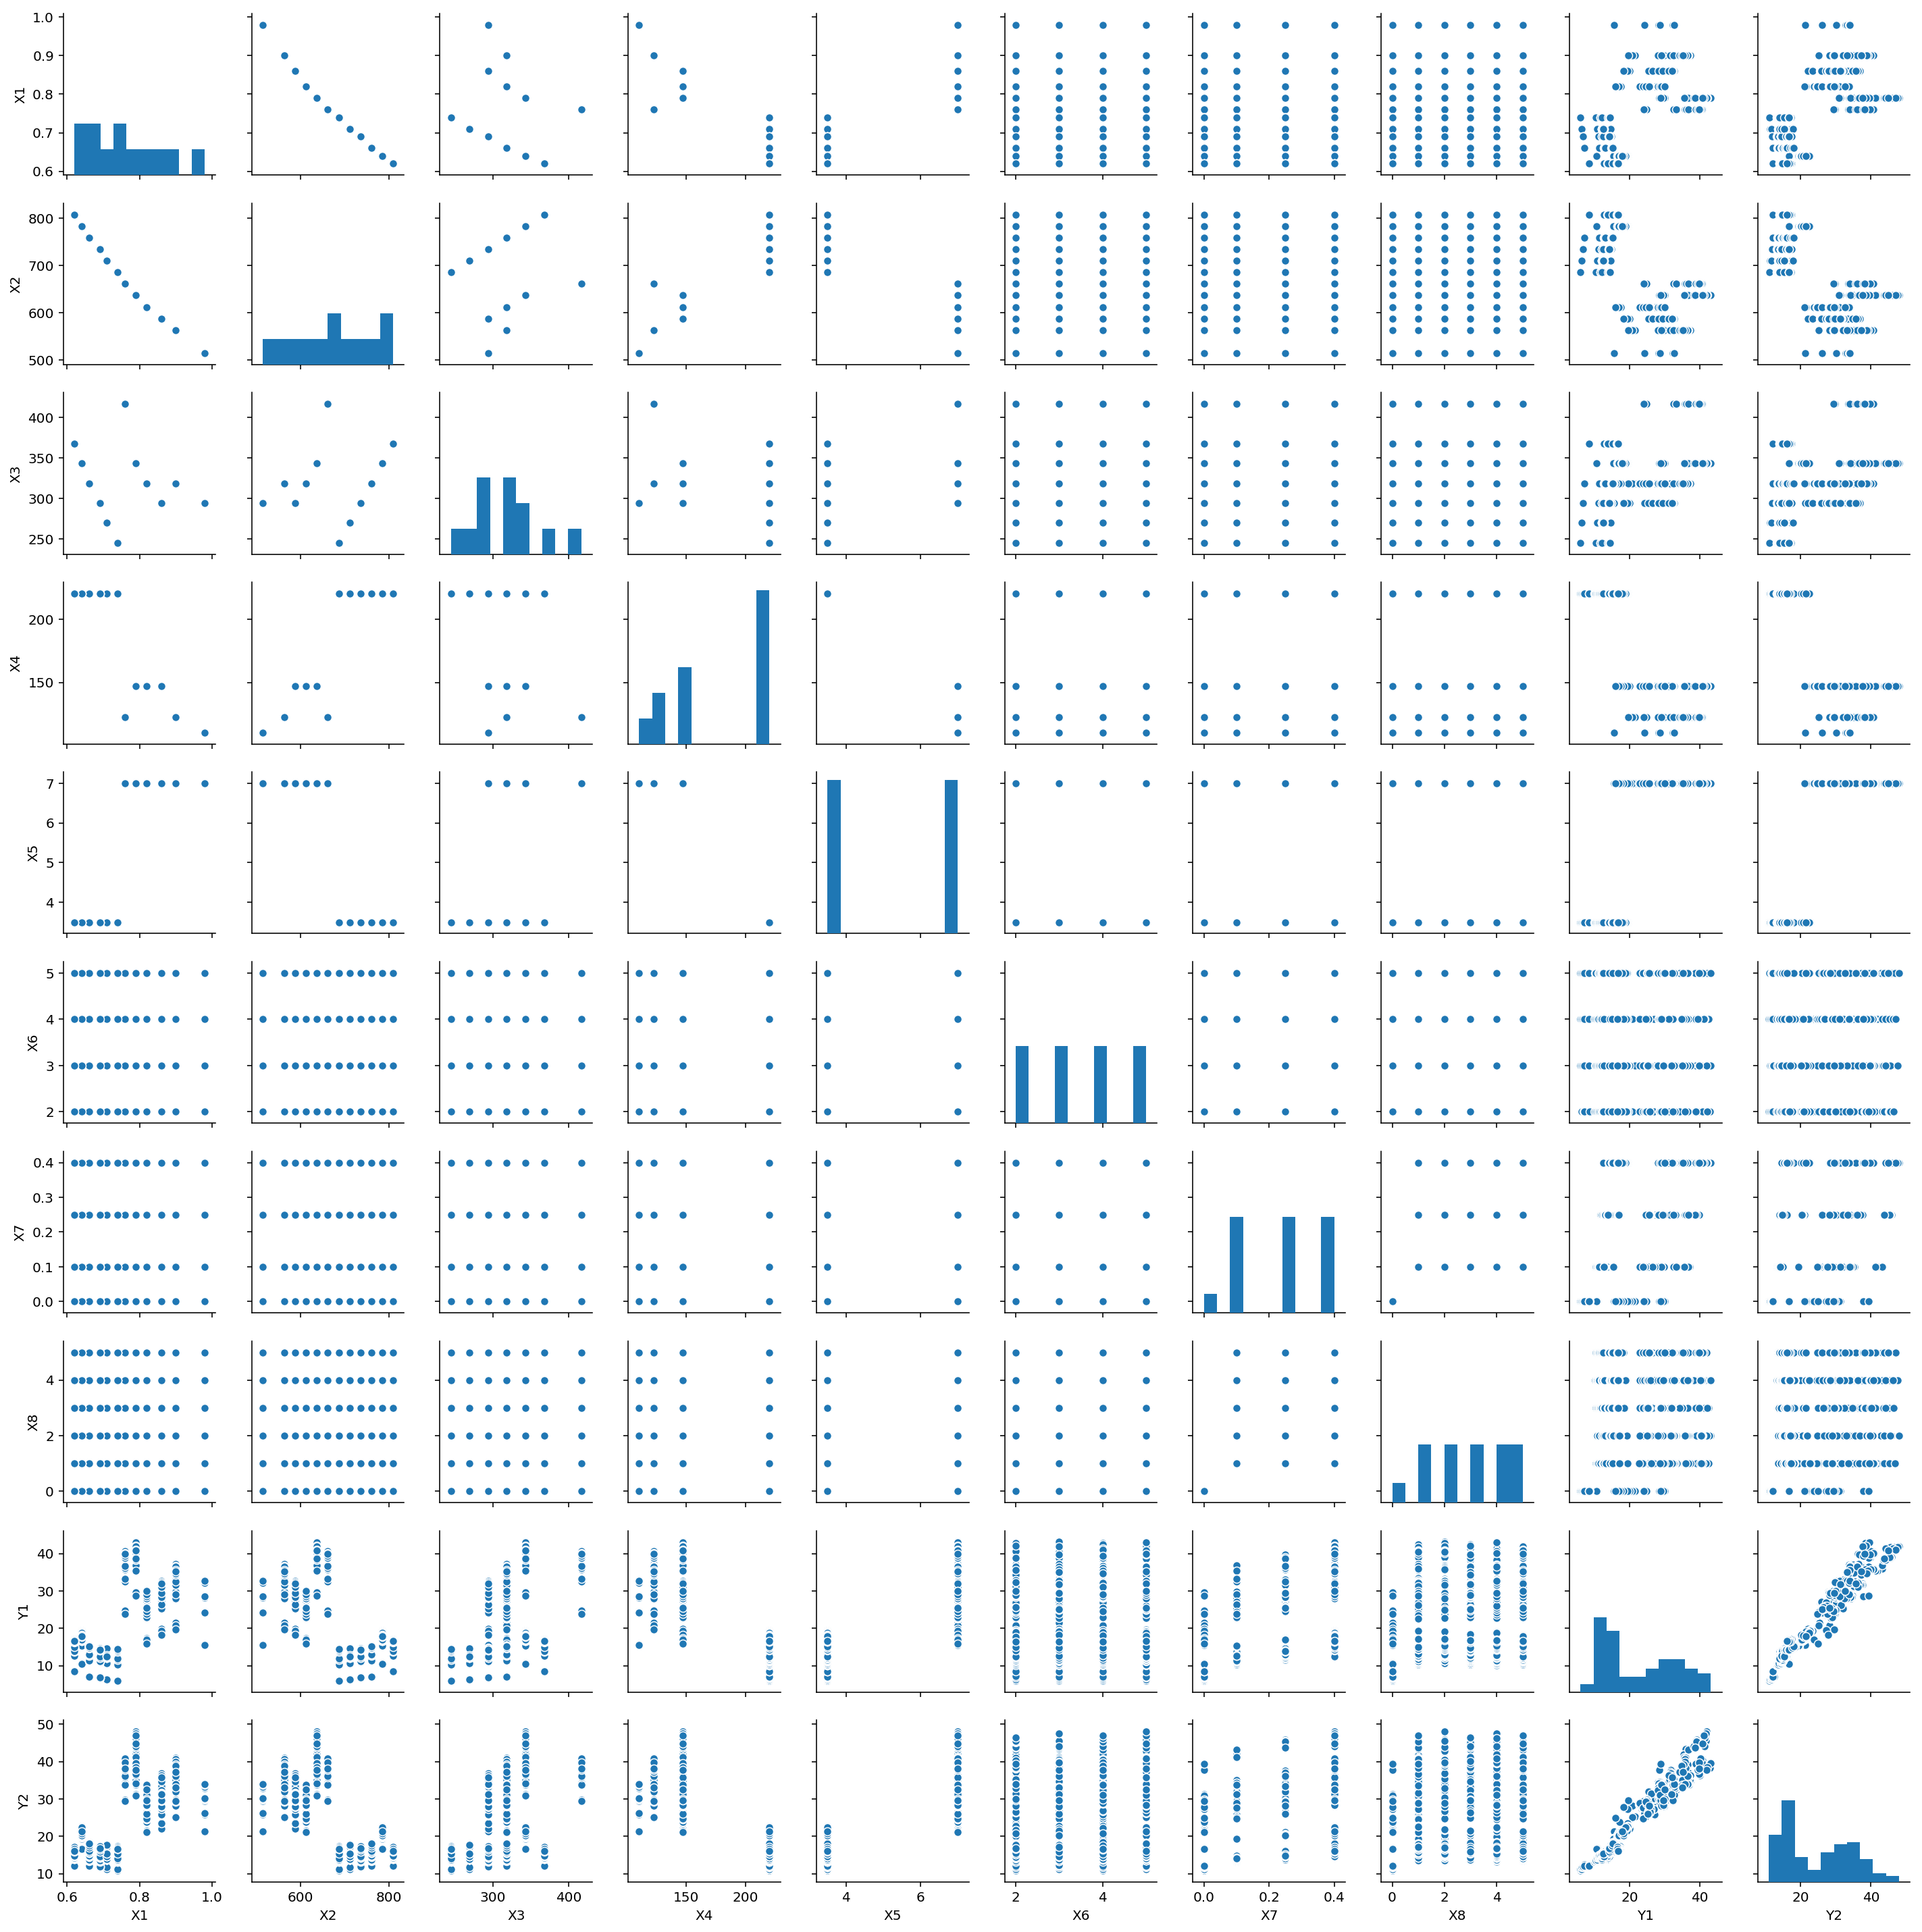

In [4]:
## 查看数据的矩阵散点图
## 矩阵散点图
sns.pairplot(Enb,size=2,diag_kind="hist")
plt.show()

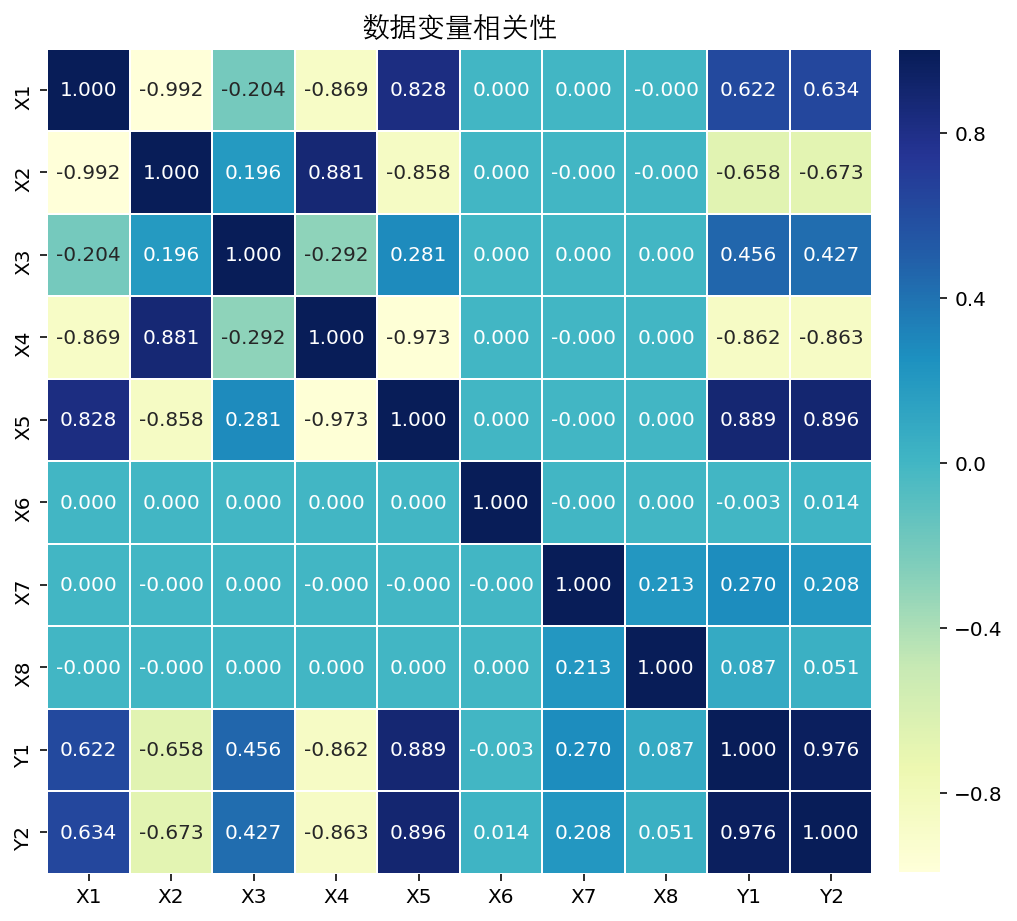

In [5]:
## 分析数据间的相关性
datacor = np.corrcoef(Enb,rowvar=0)
datacor = pd.DataFrame(data=datacor,columns=Enb.columns,index=Enb.columns)


## 热力图可视化相关系数
plt.figure(figsize=(8,8))
ax = sns.heatmap(datacor,square=True,annot=True,fmt = ".3f",
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
ax.set_title("数据变量相关性",fontproperties = fonts)
plt.show()

In [6]:
## 多元回归
formula = "Y1 ~ X1 + X2 + X3 + X4 + X5+ X6 + X7 + X8"
lm = smf.ols(formula, Enb).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1187.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:37   Log-Likelihood:                -1912.5
No. Observations:                 768   AIC:                             3841.
Df Residuals:                     760   BIC:                             3878.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.0134     19.034      4.414      0.0

**逐步回归**

In [7]:
from itertools import combinations

In [8]:
## 根据BIC和Cond. No.（条件数）根据参与回归的自变量个数来找到合适的回归模型
variable = []
aic = []
bic = []
Cond = []
R_squared = []
for ii in range(1,len(Enb.columns.values[0:-2])):
    var = list(combinations(Enb.columns.values[0:-2],ii))
    for v in var:
        formulav = "Y1"+"~"+"+".join(v)
        lm = smf.ols(formulav, Enb).fit()
        bic.append(lm.bic)
        aic.append(lm.aic)
        variable.append(v)
        Cond.append(lm.condition_number)
        R_squared.append(lm.rsquared)
    
    

In [9]:
## 将输出的参数组合成数据表，并根据bic排序
df = pd.DataFrame()
df["variable"] = variable
df["bic"] = bic
df["aic"] = aic
df["Cond"] = Cond
df["R_squared"] = R_squared
df.sort_values("bic",ascending=True)[df.Cond<300].head(5)


,variable,bic,aic,Cond,R_squared
125,"(X1, X5, X7, X8)",3945.699224,3922.480276,119.860326,0.906082
52,"(X1, X5, X7)",3946.676351,3928.101192,107.466389,0.905145
196,"(X1, X5, X6, X7, X8)",3952.288295,3924.425557,136.916903,0.906088
123,"(X1, X5, X6, X7)",3953.265962,3930.047013,125.968890,0.905152
31,"(X5, X7)",4217.305487,4203.374118,43.578310,0.863901


In [10]:
df.sort_values("bic",ascending=True).head(5)

,variable,bic,aic,Cond,R_squared
194,"(X1, X4, X5, X7, X8)",3869.166530,3841.303792,7.622924e+03,0.915722
118,"(X1, X4, X5, X7)",3871.010575,3847.791626,7.617974e+03,0.914785
235,"(X1, X3, X4, X5, X7, X8)",3871.481357,3838.974828,7.463448e+04,0.916195
226,"(X1, X2, X3, X5, X7, X8)",3871.481357,3838.974828,1.525005e+05,0.916195
248,"(X1, X2, X3, X4, X5, X7, X8)",3871.481357,3838.974828,1.455526e+16,0.916195


可以发现bic最小的回归方程只用到了(X1, X4, X5, X7, X8)5个自变量，并且R2 ＝ 0.9157，接下来使用5个自变量进行多元回归分析

In [11]:
formula = "Y1 ~ X1 + X4 + X5+ X7 + X8"
lm = smf.ols(formula, Enb).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1656.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:40   Log-Likelihood:                -1914.7
No. Observations:                 768   AIC:                             3841.
Df Residuals:                     762   BIC:                             3869.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.4486      4.186     10.859      0.0

In [12]:
Y_pre = lm.predict(Enb)
metrics.mean_absolute_error(Y_pre,Enb.Y1)

2.085389464452644

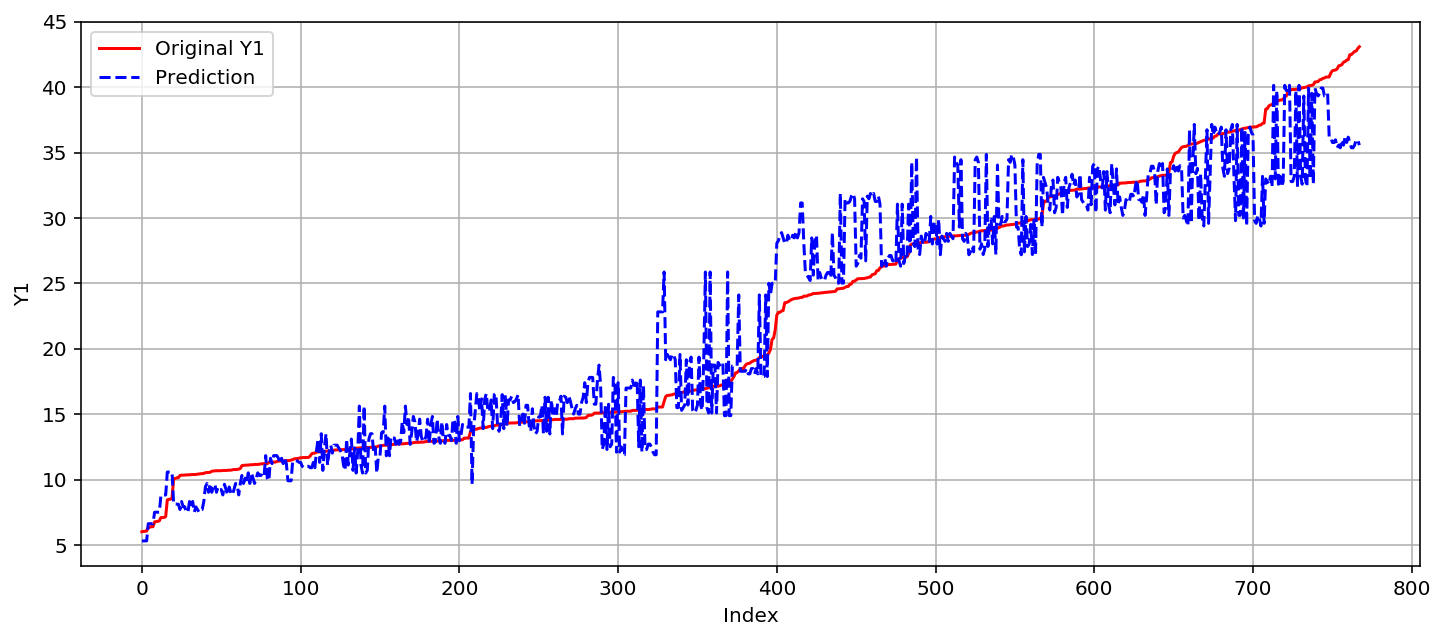

In [13]:
## 绘制回归的预测结果和原始数据的差异
Y_pre = lm.predict(Enb)
index = np.argsort(Enb.Y1)
plt.figure(figsize=(12,5))
plt.plot(np.arange(Enb.shape[0]),Enb.Y1[index],"r",label = "Original Y1")
plt.plot(np.arange(Enb.shape[0]),Y_pre[index],"b--",label = "Prediction")
plt.legend()
plt.grid("on")
plt.xlabel("Index")
plt.ylabel("Y1")
plt.show()

**使用LASSO回归**

In [14]:
## 糖尿病数据集
diabete = pd.read_csv("data/chap5/diabetes.csv",sep="\t")
print(diabete.sample(5))


     AGE  SEX   BMI     BP   S1     S2    S3    S4      S5   S6    Y
37    46    1  27.4  78.00  171   88.0  58.0  3.00  4.8283   90  276
414   71    2  27.0  93.33  269  190.2  41.0  6.56  5.2417   93  131
3     24    1  25.3  84.00  198  131.4  40.0  5.00  4.8903   89  206
27    42    1  31.9  83.00  158   87.6  53.0  3.00  4.4659  101   85
403   43    1  35.4  93.00  185  100.2  44.0  4.00  5.3181  101  275


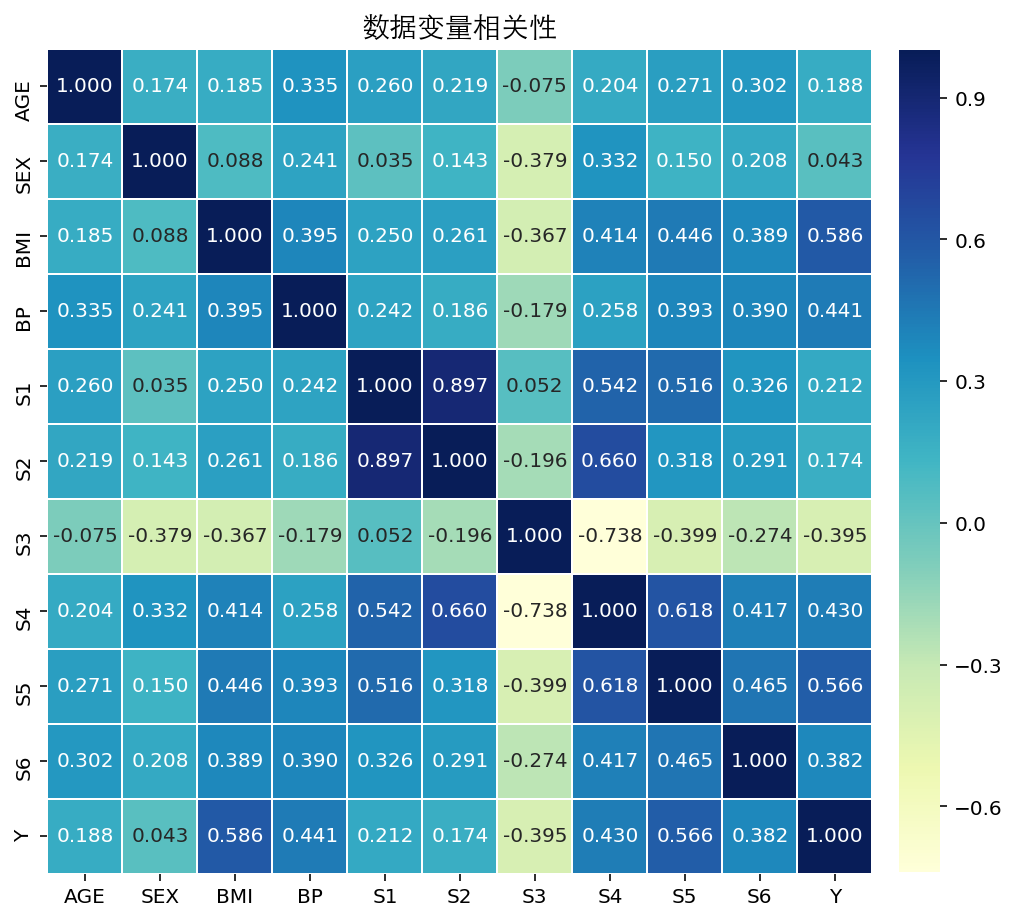

In [15]:
## 分析数据间的相关性
datacor = np.corrcoef(diabete,rowvar=0)
datacor = pd.DataFrame(data=datacor,columns=diabete.columns,index=diabete.columns)


## 热力图可视化相关系数
plt.figure(figsize=(8,8))
ax = sns.heatmap(datacor,square=True,annot=True,fmt = ".3f",
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
ax.set_title("数据变量相关性",fontproperties = fonts)
plt.show()

In [16]:
## 定义回归函数
from sklearn.linear_model import  Ridge
from sklearn.metrics import r2_score,mean_absolute_error
def ridge_regression(data,test, predictors,pre_y, alpha):
    # 拟合模型
    ridgereg = Ridge(alpha=alpha,normalize=True, max_iter=1e5)
    ridgereg.fit(data[predictors],data[pre_y])
    y_pred = ridgereg.predict(test[predictors])
    
    # 输出模型的结果
    ret = [alpha]
    ret.append(r2_score(test[pre_y],y_pred))
    ret.append(mean_absolute_error(test[pre_y],y_pred))
    ret.extend(ridgereg.coef_)
    return ret

In [17]:
## 建立lasso回归模型
# 初始化预测自变量 和预测因变量
predictors= ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
prey = "Y"
# 定义alpha的取值范围
alpha_ridge = np.linspace(0.00005,2,20)

# 初始化数据表用来板寸系数和得分
col = ['alpha','r2_score','mae','AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,len(alpha_ridge))]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

## 百分之80的数据用于训练，剩余的数据用于测试
np.random.seed(24)
index = np.random.permutation(diabete.shape[0])
trainindex = index[1:350]
testindex = index[350:-1]
diabete_train = diabete.iloc[trainindex,:]
diabete_test = diabete.iloc[testindex,:]

#根据alpha的值迭代:
for i in range(len(alpha_ridge)):
    coef_matrix_ridge.iloc[i,] = ridge_regression(diabete_train,diabete_test,predictors,prey, alpha_ridge[i])

coef_matrix_ridge.sample(5)

,alpha,r2_score,mae,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
alpha_0.63,0.631613,0.309937,50.0384,0.0380622,-9.83878,3.72816,0.787316,0.00572716,-0.0422963,-0.630602,5.35402,31.5309,0.460336
alpha_1.2,1.15792,0.28776,51.1886,0.0822511,-5.98061,3.02832,0.658232,0.0284174,-0.00778879,-0.552122,5.04432,25.4902,0.454249
alpha_0.42,0.421092,0.319137,49.2657,0.00448751,-12.3782,4.13004,0.858668,-0.0130137,-0.0613542,-0.667354,5.4132,35.3287,0.445269
alpha_0.21,0.210571,0.326522,48.6017,-0.047379,-15.9682,4.64948,0.948534,-0.0531787,-0.073257,-0.699599,5.31778,41.0711,0.40293
alpha_1.3,1.26318,0.283735,51.3599,0.0872204,-5.46596,2.9224,0.638081,0.0310314,-0.00299314,-0.538749,4.97484,24.6115,0.449945


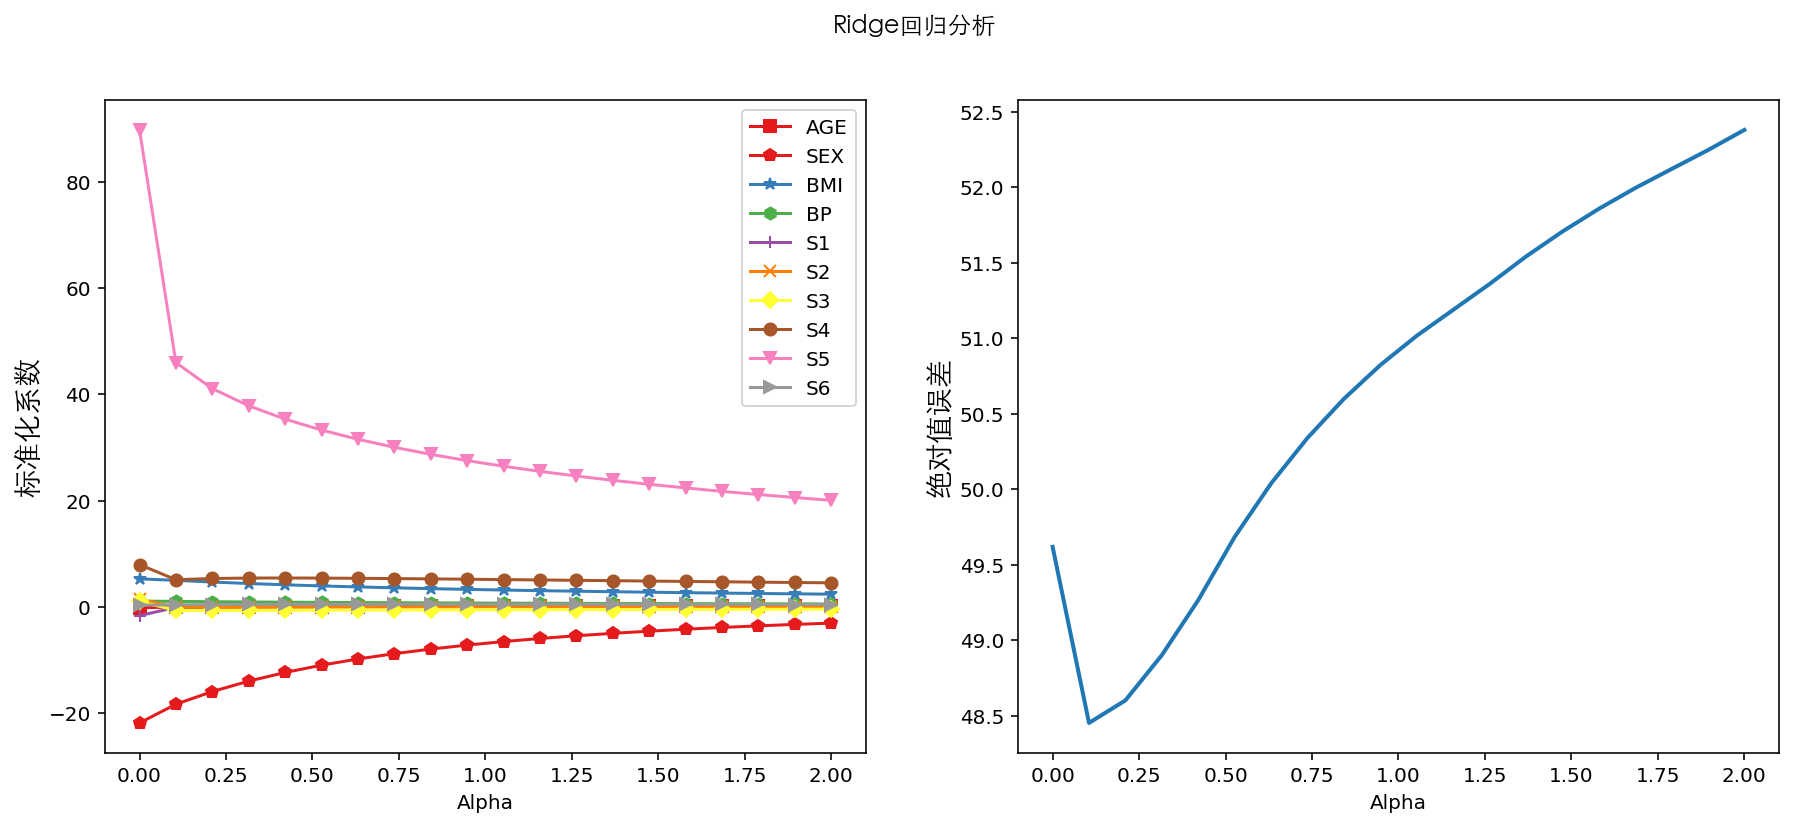

In [18]:
ploty = ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
shape = ["s","p","*","h","+","x","D","o","v",">"]
plt.figure(figsize=(15,6))
plt.grid("on")
plt.subplot(1,2,1)
for ii in np.arange(len(ploty)):
    plt.plot(coef_matrix_ridge["alpha"],coef_matrix_ridge[ploty[ii]],
             color = plt.cm.Set1(ii / len(ploty)),label = ploty[ii],
            marker = shape[ii])
    
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("标准化系数",FontProperties = fonts)
    

plt.subplot(1,2,2)
plt.plot(coef_matrix_ridge["alpha"],coef_matrix_ridge["mae"],linewidth = 2)
plt.xlabel("Alpha")
plt.ylabel("绝对值误差",FontProperties = fonts)
plt.suptitle("Ridge回归分析",FontProperties = fonts)
# plt.ylim(30,100)
plt.show()


**使用Lasso回归来建立回归模型:选择合适的alpha**

In [19]:
## 定义回归函数
from sklearn.linear_model import  Lasso
from sklearn.metrics import r2_score,mean_absolute_error
def lasso_regression(data,test, predictors,pre_y, alpha):
    # 拟合模型
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5,fit_intercept=False)
    lassoreg.fit(data[predictors],data[pre_y])
    y_pred = lassoreg.predict(test[predictors])
    
    # 输出模型的结果
    ret = [alpha]
    ret.append(r2_score(test[pre_y],y_pred))
    ret.append(mean_absolute_error(test[pre_y],y_pred))
    ret.extend(lassoreg.coef_)
    return ret

In [20]:
## 建立lasso回归模型
# 初始化预测自变量 和预测因变量
predictors= ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
prey = "Y"
# 定义alpha的取值范围
alpha_lasso = np.linspace(0.00005,2,20)

# 初始化数据表用来板寸系数和得分
col = ['alpha','r2_score','mae','AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)


In [21]:
## 百分之80的数据用于训练，剩余的数据用于测试
np.random.seed(123456)
index = np.random.permutation(diabete.shape[0])
trainindex = index[0:350]
testindex = index[350:-1]
diabete_train = diabete.iloc[trainindex,:]
diabete_test = diabete.iloc[testindex,:]

#Iterate over the alpha values:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(diabete_train,diabete_test,predictors,prey, alpha_lasso[i])

coef_matrix_lasso.sample(5)

,alpha,r2_score,mae,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
alpha_0.74,0.736874,0.506942,42.0928,-0,-26.7699,5.46539,1.0916,1.27331,-1.3599,-2.95785,-3.48663,0,0.251971
alpha_0.84,0.842134,0.507771,42.1005,-0,-26.354,5.45697,1.08617,1.26564,-1.36014,-2.93362,-3.15114,0,0.241503
alpha_1.9,1.89474,0.514245,42.2896,-0,-22.1474,5.37782,1.03198,1.19377,-1.36285,-2.70374,-0,0,0.140548
alpha_1.7,1.68422,0.513242,42.2435,-0,-23.0261,5.38958,1.04273,1.20427,-1.36209,-2.73984,-0.467467,0,0.157766
alpha_1.2,1.15792,0.510065,42.1516,-0,-25.106,5.4317,1.06988,1.24262,-1.36087,-2.86095,-2.14472,0,0.210102


In [22]:
coef_matrix_lasso.sort_values("mae").head(5)

,alpha,r2_score,mae,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
alpha_0.42,0.421092,0.501711,42.0681,-0.00151581,-28.5873,5.34031,1.08059,1.19015,-1.23554,-3.04802,-5.80812,4.95494,0.245106
alpha_0.32,0.315832,0.499511,42.0705,-0.00366962,-29.2134,5.29213,1.07608,1.15806,-1.18886,-3.07893,-6.63968,6.81898,0.24145
alpha_0.53,0.526353,0.503724,42.0772,-0,-27.9597,5.38844,1.08522,1.22229,-1.28222,-3.01716,-4.97766,3.0923,0.248867
alpha_0.63,0.631613,0.505547,42.0853,-0,-27.3284,5.43643,1.09014,1.25453,-1.32887,-2.98645,-4.14983,1.23304,0.252872
alpha_0.74,0.736874,0.506942,42.0928,-0,-26.7699,5.46539,1.0916,1.27331,-1.3599,-2.95785,-3.48663,0,0.251971


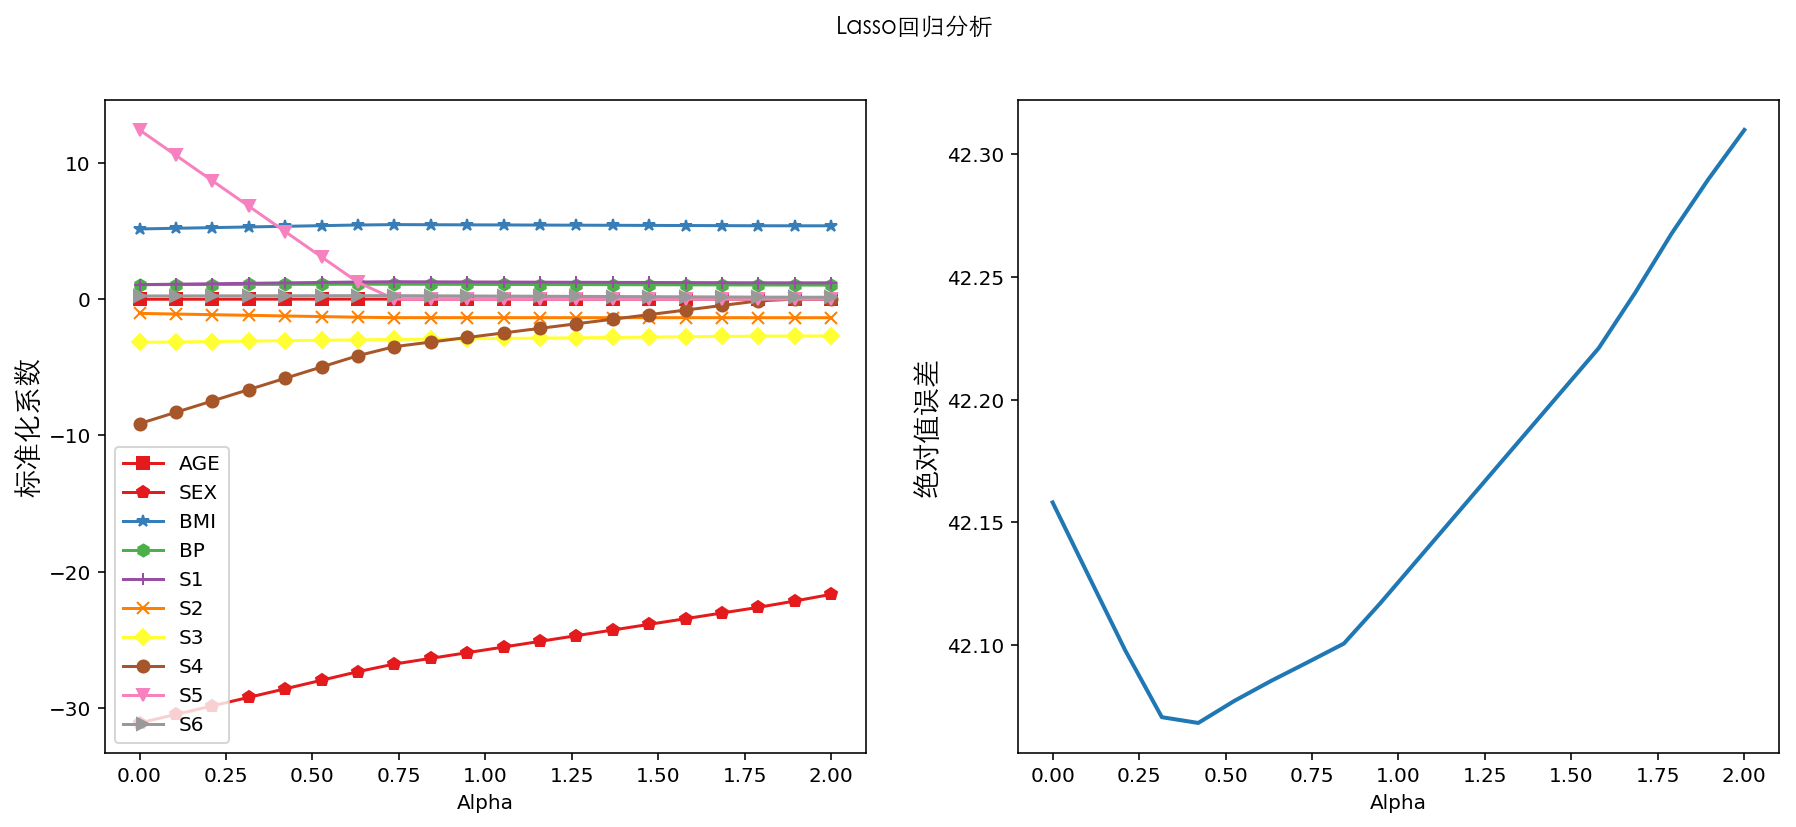

In [23]:
ploty = ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
shape = ["s","p","*","h","+","x","D","o","v",">"]
plt.figure(figsize=(15,6))
plt.grid("on")
plt.subplot(1,2,1)
for ii in np.arange(len(ploty)):
    plt.plot(coef_matrix_lasso["alpha"],coef_matrix_lasso[ploty[ii]],
             color = plt.cm.Set1(ii / len(ploty)),label = ploty[ii],
            marker = shape[ii])
    
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("标准化系数",FontProperties = fonts)
    

plt.subplot(1,2,2)
plt.plot(coef_matrix_lasso["alpha"],coef_matrix_lasso["mae"],linewidth = 2)
plt.xlabel("Alpha")
plt.ylabel("绝对值误差",FontProperties = fonts)
plt.suptitle("Lasso回归分析",FontProperties = fonts)
plt.show()


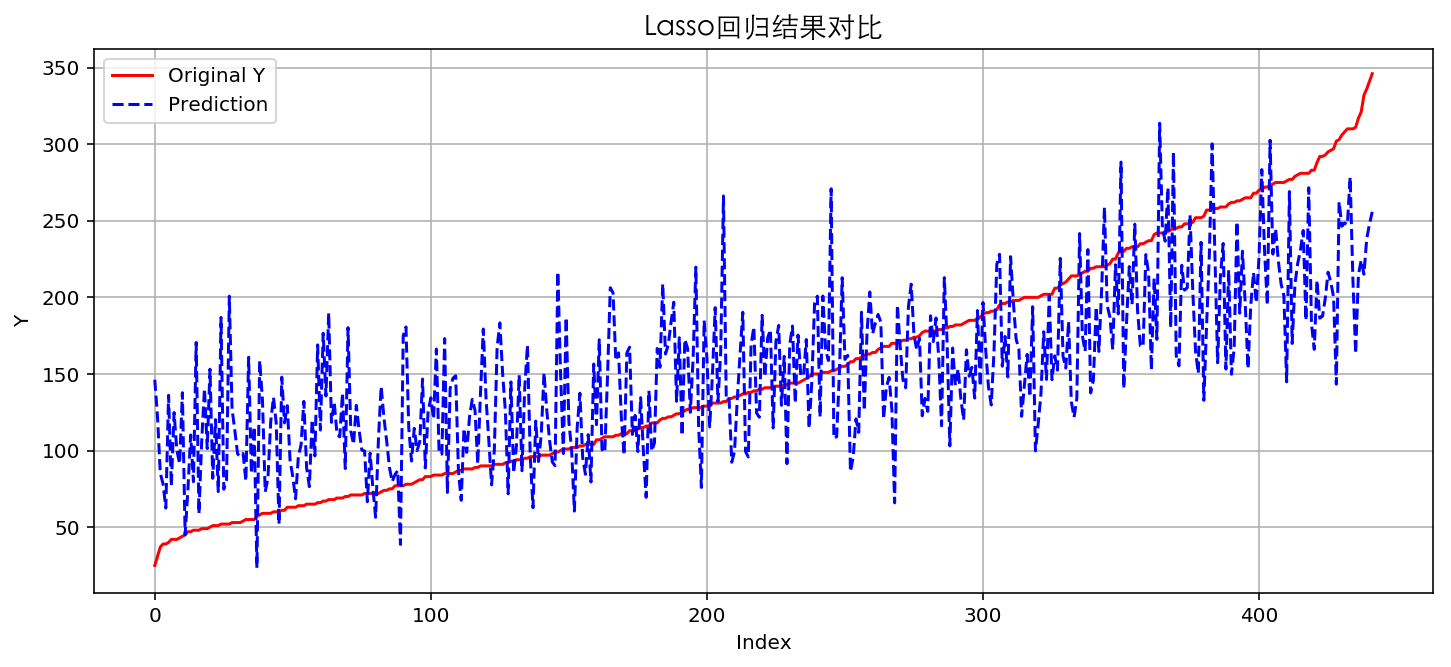

In [24]:
# 对全部的数据集拟合模型
lassoreg = Lasso(alpha=0.736874,normalize=True, 
                 max_iter=1e5,fit_intercept=False)
lassoreg.fit(diabete[predictors],diabete[prey])
Y_pre = lassoreg.predict(diabete[predictors])
## 绘制回归的预测结果和原始数据的差异
index = np.argsort(diabete.Y)
plt.figure(figsize=(12,5))
plt.plot(np.arange(diabete.shape[0]),diabete.Y[index],"r",label = "Original Y")
plt.plot(np.arange(diabete.shape[0]),Y_pre[index],"b--",label = "Prediction")
plt.legend()
plt.grid("on")
plt.xlabel("Index")
plt.ylabel("Y")
plt.title("Lasso回归结果对比",FontProperties = fonts)
plt.show()

 ### logistic回归分析
 
 logistic回归分析主要用来做分类，下面以信用卡数据集来实现logistic回归分析。
 
 https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
 
 信用卡是否违约数据集

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
## 读取数据集
credit = pd.read_excel("data/chap5/default of credit card clients.xls")
credit.head(5)

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [27]:
## 30000个样本，23个自变量
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      30000 non-null  int64
 1   X1      30000 non-null  int64
 2   X2      30000 non-null  int64
 3   X3      30000 non-null  int64
 4   X4      30000 non-null  int64
 5   X5      30000 non-null  int64
 6   X6      30000 non-null  int64
 7   X7      30000 non-null  int64
 8   X8      30000 non-null  int64
 9   X9      30000 non-null  int64
 10  X10     30000 non-null  int64
 11  X11     30000 non-null  int64
 12  X12     30000 non-null  int64
 13  X13     30000 non-null  int64
 14  X14     30000 non-null  int64
 15  X15     30000 non-null  int64
 16  X16     30000 non-null  int64
 17  X17     30000 non-null  int64
 18  X18     30000 non-null  int64
 19  X19     30000 non-null  int64
 20  X20     30000 non-null  int64
 21  X21     30000 non-null  int64
 22  X22     30000 non-null  int64
 23  X23     300

In [28]:
## 6636个不违约，其余的违约
credit["Y"].sum()

6636

In [29]:
## 数据集切分
trainx = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23']
Target = ["Y"]
##将训练集切分为训练集和验证集
traindata_x,valdata_x,traindata_y,valdata_y = train_test_split(
    credit[trainx],credit[Target],test_size = 0.25,random_state = 1)
traindata_x.sample(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
22115,300000,2,1,2,28,-2,-2,-2,-2,-2,...,744,2826,0,18525,0,744,3000,0,18525,3078
5301,90000,1,2,2,30,-1,-1,-1,0,0,...,922,552,182,312,370,922,0,0,500,600
26699,50000,1,2,2,27,0,0,0,0,0,...,50297,36164,37616,39062,2000,2500,2000,2000,2000,2000
2850,230000,2,3,1,47,-1,-1,-1,-1,-1,...,1678,0,764,0,15900,1678,0,764,0,1321
10891,140000,1,2,2,41,0,0,0,0,0,...,92446,65774,65076,64295,3551,3814,2333,2340,2279,2273


In [30]:
traindata_y.sum()

Y    4968
dtype: int64

In [31]:
clf_l1_LR = LogisticRegression(penalty='l1')
clf_l1_LR.fit(traindata_x,traindata_y)
pre_y = clf_l1_LR.predict(valdata_x)
print(metrics.classification_report(valdata_y,pre_y))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      5832
           1       0.71      0.22      0.34      1668

    accuracy                           0.81      7500
   macro avg       0.76      0.60      0.61      7500
weighted avg       0.79      0.81      0.77      7500



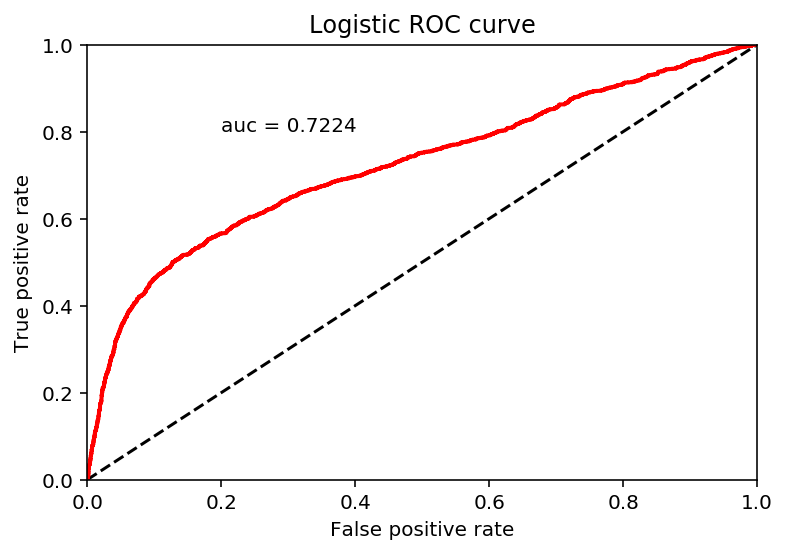

In [32]:
## plot ROC曲线
pre_y_p = clf_l1_LR.predict_proba(valdata_x)[:, 1]

fpr_LR, tpr_LR, _ = metrics.roc_curve(valdata_y, pre_y_p)
auc = metrics.auc(fpr_LR, tpr_LR)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LR, tpr_LR,"r",linewidth = 2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Logistic ROC curve')
plt.text(0.2,0.8,"auc = "+str(round(auc,4)))
plt.show()

### 时间序列模型 ARIMA

##### ARIMA模型运用的流程
1:根据时间序列的散点图、自相关函数和偏自相关函数图识别其平稳性。

2:对非平稳的时间序列数据进行平稳化处理。直到处理后的自相关函数和偏自相关函数的数值非显著非零。

3:根据所识别出来的特征建立相应的时间序列模型。平稳化处理后，若偏自相关函数是截尾的，而自相关函数是拖尾的，则建立AR模型；若偏自相关函数是拖尾的，而自相关函数是截尾的，则建立MA模型；若偏自相关函数和自相关函数均是拖尾的，则序列适合ARMA模型。

4:参数估计，检验是否具有统计意义。

5:假设检验，判断（诊断）残差序列是否为白噪声序列。

6:利用已通过检验的模型进行预测。

In [33]:
## 读取飞机乘客数量的数据集
Airp = pd.read_csv("data/chap5/AirPassengers.csv",index_col="Month")
Airp = Airp.astype("float64",copy=False) ## 调整数据类型
## 调整数据索引
Airp.index = pd.date_range(start="1949",end="1960-12",freq="MS")
Airp.head(5)

,Passengers
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [34]:
## 读取飞机乘客数量的数据集
Airp = pd.read_csv("data/chap5/AirPassengers.csv",index_col="Month")
Airp = Airp.astype("float64",copy=False) ## 调整数据类型
## 调整数据索引
Airp.index = pd.date_range(start=Airp.index.values[0],periods=Airp.shape[0],freq="MS")
Airp.head(5)

,Passengers
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [35]:
Airp.tail(5)

,Passengers
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


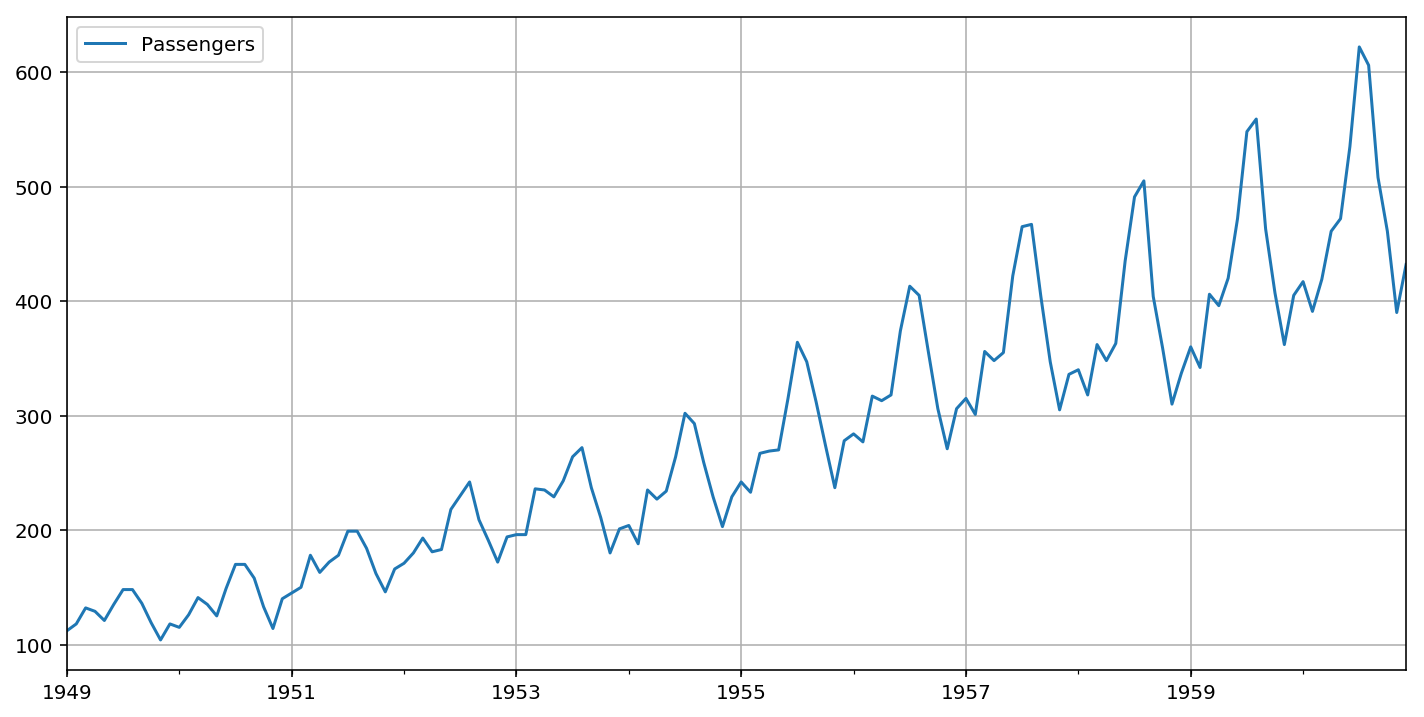

In [36]:
## 该数据集为1949年到1960年的数据集
Airp.plot(kind = "line",figsize=(12,6))
plt.grid("on")
plt.show()

In [37]:
## 时间序列的白噪声检验
## 该检验用来检查序列是否为随机序列，如果是随机序列，那它们的值之间没有任何关系
## 使用LB检验来检验序列是否为白噪声，原假设为在延迟期数内序列之间相互独立。
lags = [4,8,12,16,20,24,28,32,36,64,128]
LB = sm.stats.diagnostic.acorr_ljungbox(Airp,lags = lags)
LB = pd.DataFrame(data = np.array(LB).T,columns=["LBvalue","P-value"])
LB["lags"] = lags
LB

,LBvalue,P-value,lags
0,427.738684,2.817731e-91,4
1,709.484498,6.496271e-148,8
2,1036.481907,2.682212e-214,12
3,1289.037076,1.137910e-264,16
4,1434.148907,5.300473e-292,20
5,1606.083817,0.000000e+00,24
6,1732.279706,0.000000e+00,28
7,1792.523003,0.000000e+00,32
8,1866.625062,0.000000e+00,36
9,1960.328857,0.000000e+00,64


从上面的LB检验的P值，都远小于0.05，说明我们可以拒绝原假设，不能认为序列为白噪声。

In [38]:
##  序列的单位根检验，即检验序列的平稳性
dftest = sm.tsa.adfuller(Airp.Passengers,autolag='BIC')
print("adf:",dftest[0])
print("pvalue:",dftest[1])
print("usedlag:",dftest[2])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

adf: 0.815368879206047
pvalue: 0.991880243437641
usedlag: 13


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64

从P值>0.05说明我们不可以拒绝原假设，认为序列是不平稳的。因为不平稳可以确定参数i！=0

       Passengers
count  143.000000
mean     2.237762
std     33.754282
min   -101.000000
25%    -16.000000
50%      4.000000
75%     22.500000
max     87.000000


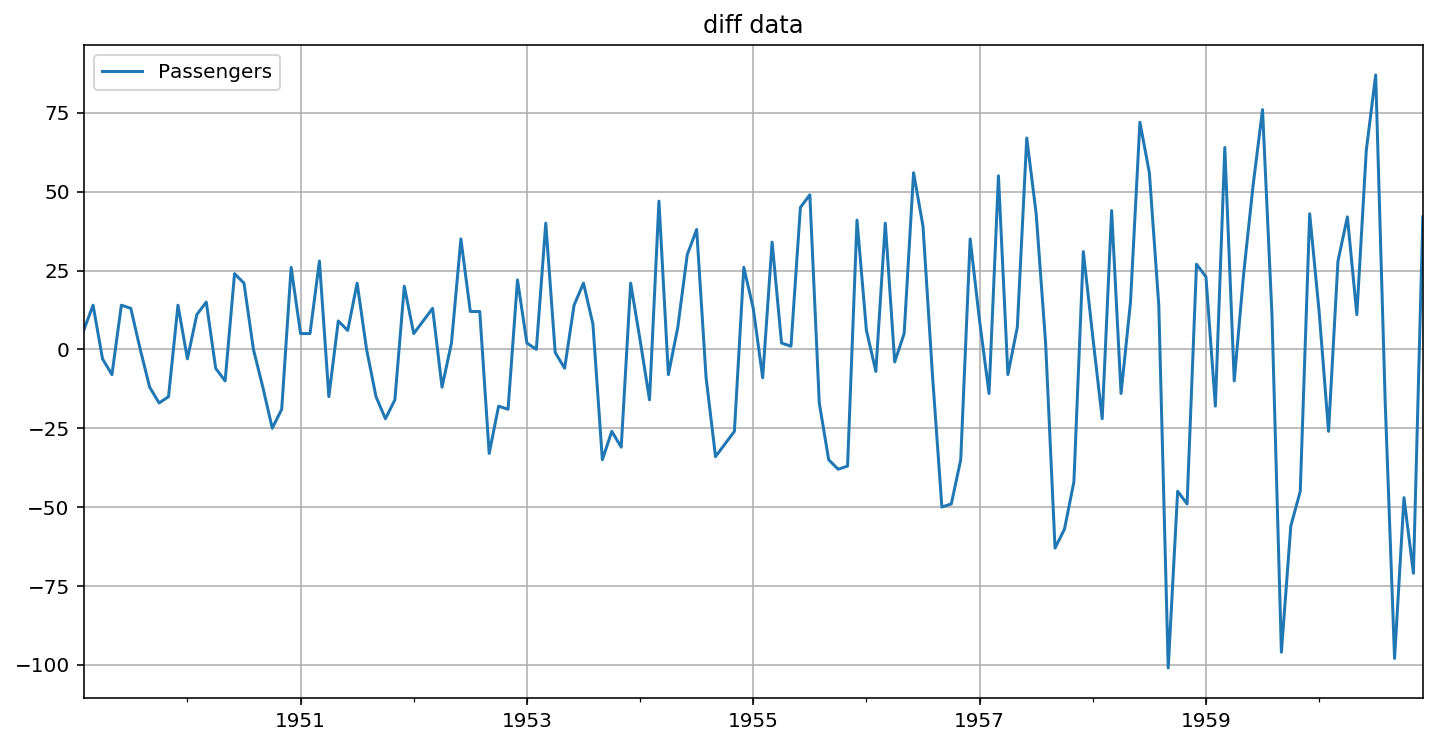

In [39]:
## 对数据进行一阶差分
datadiff = Airp.diff().dropna()
print(datadiff.describe())
## 将时间序列可视化
datadiff.plot(kind = "line",figsize=(12,6))
plt.grid("on")
plt.title('diff data')
plt.show()

In [40]:
## 一阶差分后序列的白噪声检验
## 该检验用来检查序列是否为随机序列，如果是随机序列，那它们的值之间没有任何关系
## 使用LB检验来检验序列是否为白噪声，原假设为在延迟期数内序列之间相互独立。
lags = [4,8,12,16,20,24,28,32,36,64,128]
LB = sm.stats.diagnostic.acorr_ljungbox(datadiff,lags = lags)
LB = pd.DataFrame(data = np.array(LB).T,columns=["LBvalue","P-value"])
LB["lags"] = lags
print("差分后序列的白噪声检验:\n",LB)
print("-------------------")
##  差分后序列的单位根检验，即检验序列的平稳性
dftest = sm.tsa.adfuller(datadiff.Passengers,autolag='AIC')
print("adf:",dftest[0])
print("pvalue:",dftest[1])
print("usedlag:",dftest[2])
# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# print("差分后序列的单位根检验:\n",dfoutput)

差分后序列的白噪声检验:
        LBvalue       P-value  lags
0    37.010908  1.792006e-07     4
1    53.920949  7.151547e-09     8
2   182.727561  1.175064e-32    12
3   214.146094  1.079352e-36    16
4   231.758539  5.312981e-38    20
5   334.364925  1.891849e-56    24
6   360.007662  2.410279e-59    28
7   373.697929  6.990570e-60    32
8   451.192427  3.267677e-73    36
9   627.529174  1.813356e-93    64
10  786.158482  3.299722e-95   128
-------------------
adf: -2.8292668241700056
pvalue: 0.054213290283824704
usedlag: 12


一阶差分后：进行白噪声检验，可以排除序列为白噪声；进行单位根检验时，P－value=0.054,非常接近于0.05，在置信度为90%的情况下，认为改序列是平稳的。可以确定参数 i＝1

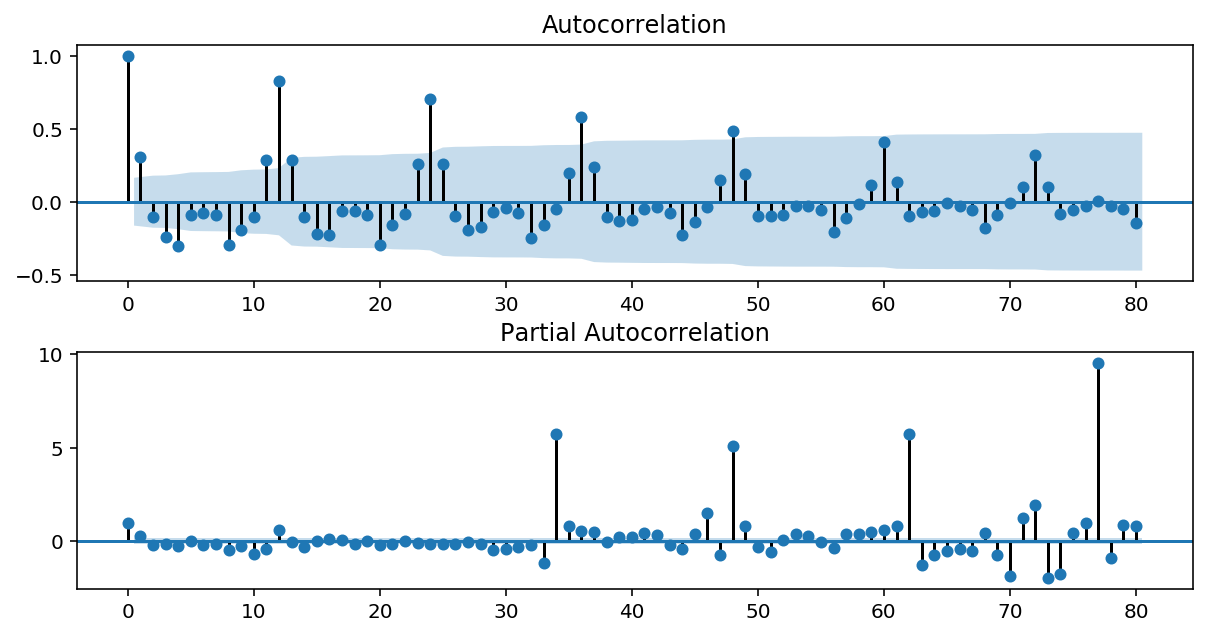

In [41]:
## 差分后序列的自相关和偏相关图
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datadiff, lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datadiff, lags=80, ax=ax2)
plt.subplots_adjust(hspace = 0.3)
plt.show()

根据自相关系数图可以确定p，根据偏相关系数图可以确定q，图中可以确定p=2;q=10

并且从图中我们也能看出相关系数的周期性的变化，通过观察自相关图，周期在12左右波动，我们可以将周期定位［12，24］等12的倍数计算多个模型，并选出最优的。seasonal_order=(1,0,8,12)中的另外三个参数的确定

In [42]:
from statsmodels.tsa.statespace.api import SARIMAX

#### ARIMAX模型

In [43]:
## 我们可以通过循环计算多个模型，通过比较bic值对模型定阶
#一般阶数不超过length/10 （我了减少运行时间）
pmax = 10
#一般阶数不超过length/10
qmax = 10
#bic矩阵

bic_matrix = [] 
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        # 存在部分报错，所以用try来跳过报错。
        try: 
#             tmp.append(sm.tsa.ARIMA(Airp, (p,1,q)).fit().bic)
            tmp.append(SARIMAX(Airp,order=(p,1,q),seasonal_order=(0,0,0,12)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
print("模型迭代结束")

模型迭代结束


In [44]:
#从中可以找出最小值
bic_matrix = pd.DataFrame(bic_matrix) 
print("bic矩阵:\n",bic_matrix)
#先用stack展平，然后用idxmin找出最小值位置。
p,q = bic_matrix.stack().idxmin() 
print("比较合适的p:",p)
print("比较合适的q:",q)

bic矩阵:
               0            1            2            3            4  \
0   1416.871962  1403.183264  1405.981996  1406.760526  1386.664233   
1   1407.777817  1403.571039  1397.348924  1401.706430  1391.565842   
2   1405.476229  1390.189698  1368.160865  1403.327598  1383.081206   
3   1406.872350  1394.428373  1394.863374  1366.666865  1374.400872   
4   1403.030393  1401.829897  1394.299865  1389.527869  1369.055526   
5   1407.911700  1406.114181  1399.056009  1394.015268  1396.710456   
6   1408.176614  1408.429774  1399.614605  1351.940462  1356.712732   
7   1410.805699  1393.669595  1401.536640          NaN  1340.059926   
8   1379.657565  1372.320462  1377.193667  1365.980631  1318.696005   
9   1380.518272  1376.105002  1380.317942  1334.689474  1319.278176   
10  1334.881281  1339.373188  1283.563164  1291.632480  1250.513385   

              5            6            7            8            9  \
0   1391.518454  1379.011520  1368.861664  1361.184608  1359.807764 

In [45]:
modl = SARIMAX(Airp,order=(10,1,8),seasonal_order=(0,0,0,12)).fit()
print(modl.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:              SARIMAX(10, 1, 8)   Log Likelihood                -574.115
Date:                Thu, 13 Feb 2020   AIC                           1186.230
Time:                        22:01:10   BIC                           1242.524
Sample:                    01-01-1949   HQIC                          1209.105
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0547      0.067      0.822      0.411      -0.076       0.185
ar.L2         -1.0192      0.083    -12.247      0.000      -1.182      -0.856
ar.L3          0.0381      0.104      0.368      0.7

In [46]:
## 使用模型进行预测
datapre = modl.predict(start=120,end= 160)

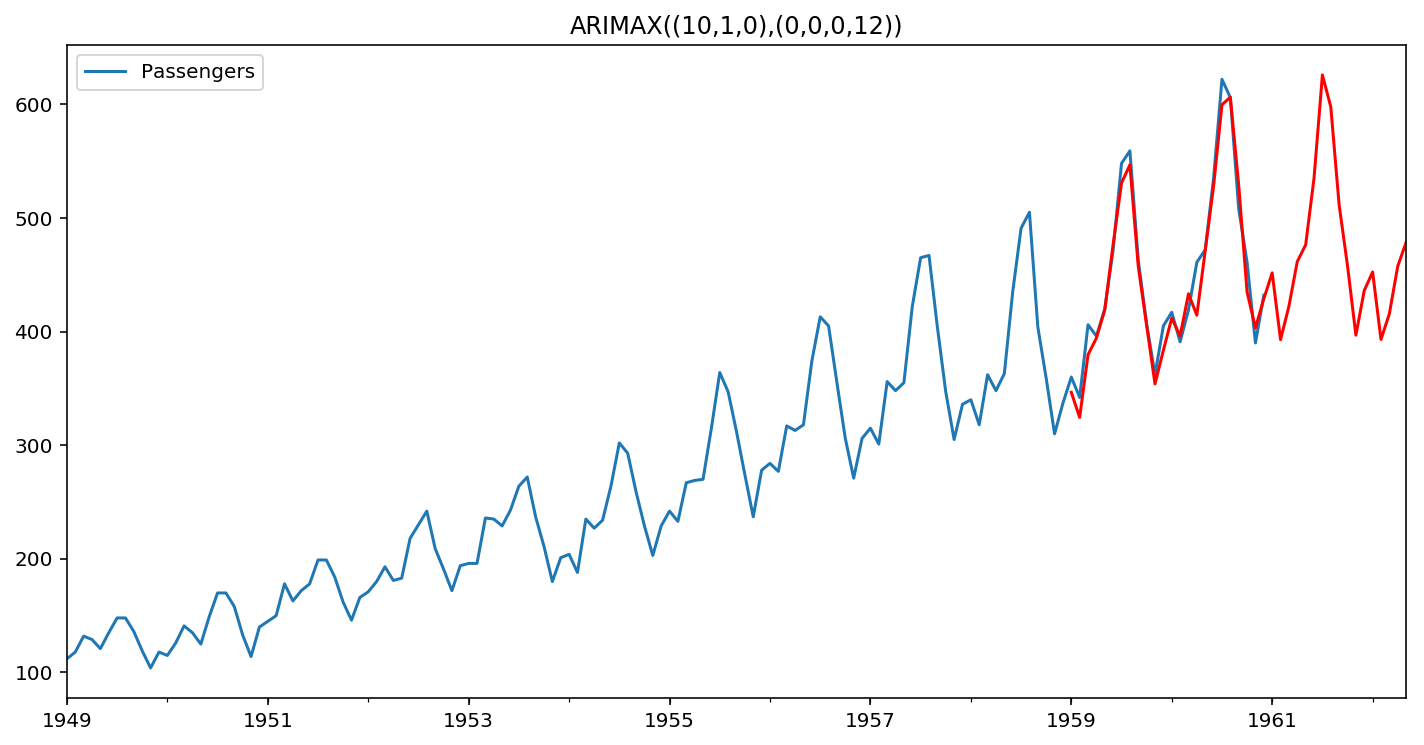

In [47]:
## 绘制原始数据和训练数据
Airp.plot(kind = "line",figsize=(12,6))
datapre.plot(kind = "line",color = "r")
# FontProperties = fonts
plt.title("ARIMAX((10,1,0),(0,0,0,12))")
plt.show()

#### ARIMA 模型

In [48]:
## 我们可以通过循环计算多个模型，通过比较bic值对模型定阶
#一般阶数不超过length/10 
pmax = 12
#一般阶数不超过length/10
qmax = 15
#bic矩阵
bic_matrix = [] 
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        # 存在部分报错，所以用try来跳过报错。
        try: 
            tmp.append(sm.tsa.ARIMA(Airp, (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
print("模型迭代结束")

模型迭代结束


In [49]:
#从中可以找出最小值
bic_matrix = pd.DataFrame(bic_matrix) 
# print("bic矩阵:\n",bic_matrix)
#先用stack展平，然后用idxmin找出最小值位置。
p,q = bic_matrix.astype("float").stack().idxmin() 
print("比较合适的p:",p)
print("比较合适的q:",q)
bic_matrix

比较合适的p: 12
比较合适的q: 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1421.203276,1407.715644,1410.236910,1396.478530,1375.091958,1377.960991,1369.270991,1374.014748,1354.391499,NaN,NaN,1330.281210,None,None,None,None
1,1412.361395,1413.996778,1386.629597,1390.852770,1379.906514,1370.695544,1373.862754,1354.285230,1358.851008,1370.016626,1346.614320,1351.555701,None,None,None,None
2,1409.826531,1376.510035,1361.820476,1364.018131,1362.287588,1367.248042,1372.126085,1365.238276,1351.644273,1341.164517,1351.506171,1333.918683,None,None,None,None
3,1410.965272,1380.228073,1381.489523,1360.478376,1367.246415,1371.387491,1356.123103,1361.007439,1365.070384,1343.441147,1348.906205,1337.423379,None,None,None,None
4,1406.287066,1382.455180,1379.853649,NaN,1362.583439,1365.123189,NaN,1363.149603,1344.842370,1323.113115,1324.800578,1347.136669,None,None,None,None
5,1411.235287,1387.256400,1384.739883,1375.248867,1375.791063,1370.901160,NaN,1362.078364,NaN,1312.544112,1342.463389,1325.491268,None,None,None,None
6,1410.730900,1374.573299,NaN,1375.627965,NaN,1358.041942,NaN,1365.665395,NaN,NaN,1359.275957,1339.619923,None,None,None,None
7,1412.621721,1369.938308,1341.305119,NaN,NaN,NaN,1343.509649,1369.194718,NaN,NaN,1384.461692,NaN,None,None,None,None
8,1375.130541,1338.670392,1317.074946,1325.860912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
9,1371.092298,1351.506043,NaN,1324.467093,NaN,NaN,NaN,NaN,1326.735585,NaN,NaN,NaN,None,None,None,None


In [56]:
# ARIMAmol = sm.tsa.ARIMA(Airp,order=(4,1,9)).fit()
# print(ARIMAmol.summary2())

In [55]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax = Airp.loc["1949":].plot(ax=ax,marker = "*")
# fig = ARIMAmol.plot_predict(start=143,end=168,dynamic=True,
#                             ax=ax, plot_insample=False)
# plt.xlabel("Year")
# plt.ylabel("Number")
# plt.title("ARIMA(4,1,9)")
# plt.legend(loc = "upper left")
# plt.show()

可以发现我们的ARIMA(4,1,9)模型对数据集预测效果很好

In [52]:
ARIMAmol = sm.tsa.ARIMA(Airp,order=(12,1,0)).fit()
print(ARIMAmol.summary2())

                             Results: ARIMA
Model:                 ARIMA             BIC:                  1251.5871 
Dependent Variable:    D.Passengers      Log-Likelihood:       -591.05   
Date:                  2020-02-13 22:39  Scale:                1.0000    
No. Observations:      143               Method:               css-mle   
Df Model:              13                Sample:               02-01-1949
Df Residuals:          130                                     12-01-1960
Converged:             1.0000            S.D. of innovations:  10.807    
No. Iterations:        3.0000            HQIC:                 1226.963  
AIC:                   1210.1073                                         
-------------------------------------------------------------------------
                     Coef.  Std.Err.       t       P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                2.7064      nan           nan    nan     nan   

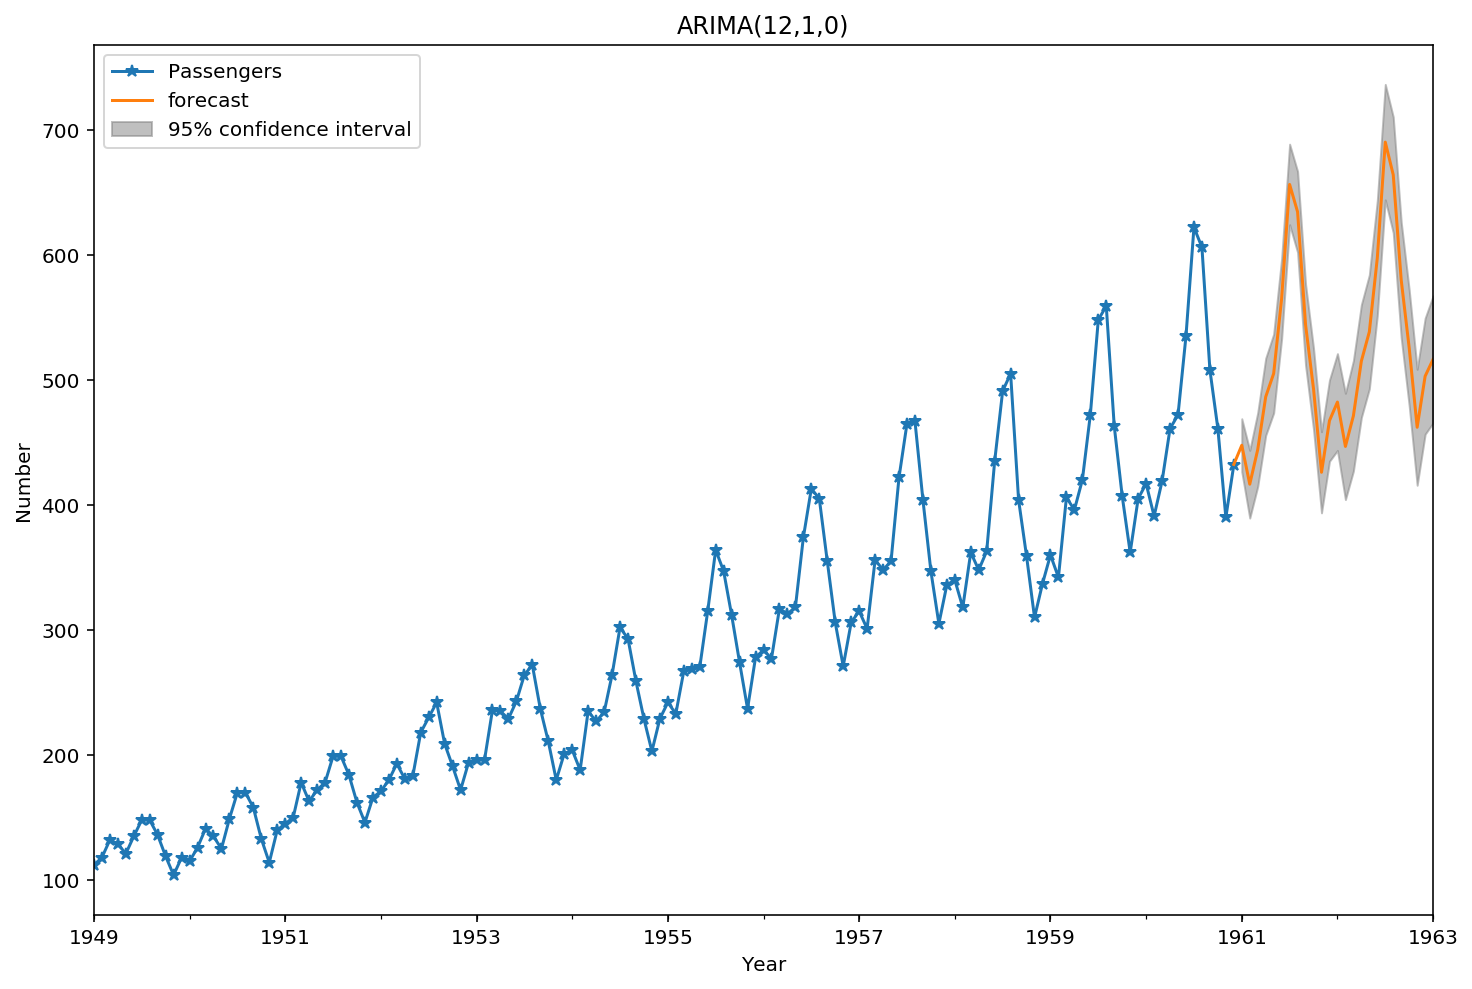

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = Airp.loc["1949":].plot(ax=ax,marker = "*")
fig = ARIMAmol.plot_predict(start=143,end=168,dynamic=True,
                            ax=ax, plot_insample=False)
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("ARIMA(12,1,0)")
plt.legend(loc = "upper left")
plt.show()